# Bagging for data valuation

This notebook introduces the Data-OOB method, an implementation based on a publication from Kwon and Zou "Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value" ICML 2023 , using pyDVL.
https://proceedings.mlr.press/v202/kwon23e.html

The objective of this paper is mainly to overcome the computational bottleneck of shapley-based data valuation methods that require to fit a significant number of models to accurately estimate marginal contributions.
The algorithms computes data values from out of bag estimates using a bagging model.

The value can be interpreted as a partition of the OOB estimate, which is originally introduced to estimate the prediction error. This OOB estimate is given as:

$$
\sum_{i=1}^n\frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1}
(w_{bi}=0)}
$$


## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
%load_ext autoreload

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import numpy as np

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std
from pydvl.value.result import ValuationResult

In [3]:

from sklearn.datasets import fetch_openml
import pandas as pd

In [5]:
#for dataset_name in ["glass", "wdbc", "cardiotocography"][-1:]:
dataset = fetch_openml(
    name="cardiotocography", version=1, as_frame=False, parser="pandas"
)
data = Dataset.from_sklearn(dataset)

In [7]:
help(fetch_openml)

Help on function fetch_openml in module sklearn.datasets._openml:

fetch_openml(name: Union[str, NoneType] = None, *, version: Union[str, int] = 'active', data_id: Union[int, NoneType] = None, data_home: Union[str, NoneType] = None, target_column: Union[str, List, NoneType] = 'default-target', cache: bool = True, return_X_y: bool = False, as_frame: Union[str, bool] = 'auto', n_retries: int = 3, delay: float = 1.0, parser: Union[str, NoneType] = 'warn', read_csv_kwargs: Union[Dict, NoneType] = None)
    Fetch dataset from openml by name or dataset id.
    
    Datasets are uniquely identified by either an integer ID or by a
    combination of name and version (i.e. there might be multiple
    versions of the 'iris' dataset). Please give either name or data_id
    (not both). In case a name is given, a version can also be
    provided.
    
    Read more in the :ref:`User Guide <openml>`.
    
    .. versionadded:: 0.20
    
    .. note:: EXPERIMENTAL
    
        The API is experimental

In [5]:

#model = KNeighborsClassifier(n_neighbors=5)
model = DecisionTreeClassifier(max_depth=5,)
#model = LogisticRegression()
utility = Utility(model, data, Scorer("accuracy", default=0.0))

# Varying cardinality

# Varying number of estimators

In [6]:
def compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, func, kwargs_list, f_name="oob"):
    all_best_scores = []
    all_worst_scores = []
    for i in range(n_iter):
        for kwargs in kwargs_list:
            #print(kwargs)
            method_name = f"{f_name}_{list(kwargs.values())[0]}"
            values = func(utility, **kwargs)

            best_scores = compute_removal_score(
                u=utility_eval,
                values=values,
                percentages=removal_percentages,
                remove_best=True,
            )
            best_scores["method_name"] = method_name
            all_best_scores.append(best_scores)
            
            worst_scores = compute_removal_score(
                u=utility_eval,
                values=values,
                percentages=removal_percentages,
                remove_best=False,
            )
            worst_scores["method_name"] = method_name
            all_worst_scores.append(worst_scores)

    best_scores_df = pd.DataFrame(all_best_scores)
    worst_scores_df = pd.DataFrame(all_worst_scores)
    return(best_scores_df, worst_scores_df)


In [7]:
def plot_best_worst(best_scores_df, worst_scores_df, palette_name="tab10", colors=None):
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,5])
    if colors is None:
        colors = sns.color_palette(palette_name, n_colors=best_scores_df.groupby("method_name").count().iloc[:,[0]].size)
    all_params = set([x.split("_")[1] for x in best_scores_df.loc[:,"method_name"].values])
    if all([x.isnumeric() for x in all_params]):
        all_params = sorted(all_params, key=lambda x: float(x))
    for i, param in enumerate(all_params):
        method_name = f"oob_{param}"
        shaded_mean_std(
            best_scores_df[best_scores_df["method_name"] == method_name].drop(
                columns=["method_name"]
            ),
            abscissa=removal_percentages,
            mean_color=colors[i%len(colors)],
            shade_color=colors[i%len(colors)],
            xlabel="Percentage removed",
            #ylabel=utility.scorer._name.capitalize(),
            label=method_name,
            title="Accuracy as a function of percentage of removed best data points",
            ax=ax[1],
        )
        shaded_mean_std(
            worst_scores_df[worst_scores_df["method_name"] == method_name].drop(
                columns=["method_name"]
            ),
            abscissa=removal_percentages,
            mean_color=colors[i%len(colors)],
            shade_color=colors[i%len(colors)],
            xlabel="Percentage removed",
            #ylabel=utility.scorer._name.capitalize(),
            label=method_name,
            title="Accuracy as a function of percentage of removed worst data points",
            ax=ax[0],
        )
    ax[0].legend();
    ax[1].legend();
    plt.show();

In [8]:
import seaborn as sns

# Test number of estimators


In [14]:
def oob_func(utility, n_est):
    return(compute_data_oob(utility, n_est=n_est, max_samples=0.6, progress=False))
n_est_list = [10,20,50, 100, 200, 1000]
func = oob_func
kwargs_list = [{"n_est":n_est} for n_est in n_est_list]

In [15]:

model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 3
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list)

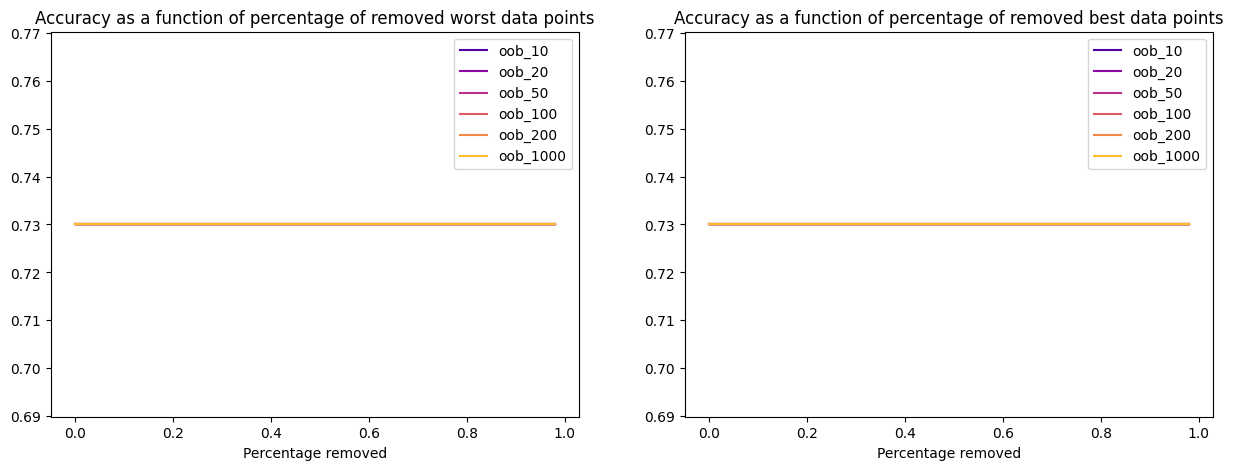

In [16]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="plasma")

# Max_samples

In [17]:
def oob_func(utility, max_samples):
    return(compute_data_oob(utility, n_est=30, max_samples=max_samples, progress=False))
max_samples_list = np.arange(0.1,0.90,0.1)
func = oob_func
kwargs_list = [{"max_samples":max_samp} for max_samp in max_samples_list]

In [18]:
model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list)

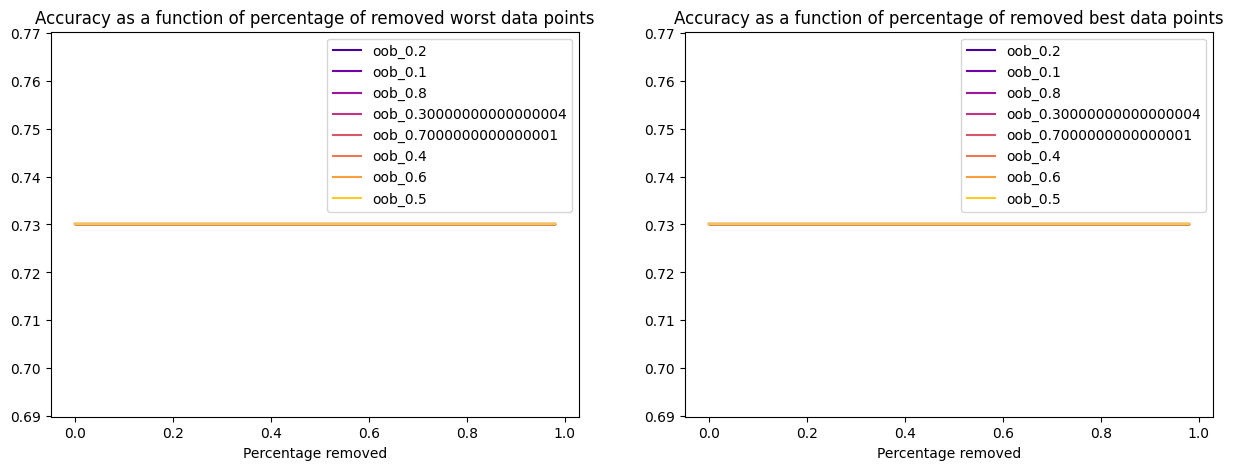

In [19]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="plasma")

# Base estimator

In [20]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF

In [21]:

model = KNeighborsClassifier(n_neighbors=5)
model = DecisionTreeClassifier(max_depth=2,)
model = LogisticRegression()
scorer = Scorer("accuracy", default=0.0)
dict_utilities = {}
utility = Utility(KNeighborsClassifier(n_neighbors=5), data, scorer)
dict_utilities["KNN"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=2,), data, scorer)
dict_utilities["DecisionTreeShallow"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=20,), data, scorer)
dict_utilities["DecisionTreeDeep"] = utility
#utility = Utility(GaussianProcessClassifier(1.0 * RBF(1.0)), data, scorer)
#dict_utilities["GaussianProcess"] = utility
#utility = Utility(GaussianNB(), data, scorer)
#dict_utilities["GaussianNB"] = utility
#utility = Utility(MLPClassifier(), data, scorer)
#dict_utilities["MLPClassifier"] = utility
utility = Utility(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), data, scorer)
dict_utilities["RandomForest"] = utility
utility = Utility(AdaBoostClassifier(), data, scorer)
dict_utilities["AdaBoost"] = utility
#utility_lr = Utility(LogisticRegression(), data, scorer)
#dict_utilities["KNN"] = utility_knn
utility = Utility(LGBMClassifier(verbose=-1), data, scorer)
dict_utilities["LGBM"] = utility

dict_utilities.keys()

dict_keys(['KNN', 'DecisionTreeShallow', 'DecisionTreeDeep', 'RandomForest', 'AdaBoost', 'LGBM'])

In [22]:
list(dict_utilities.keys())

['KNN',
 'DecisionTreeShallow',
 'DecisionTreeDeep',
 'RandomForest',
 'AdaBoost',
 'LGBM']

In [23]:
def oob_func(utility, model_name):
    return(compute_data_oob(dict_utilities[model_name], n_est=30, max_samples=0.8, progress=False))
max_samples_list = np.arange(0.1,0.90,0.1)
func = oob_func
kwargs_list = [{"model_name":m} for m in dict_utilities.keys()]

In [24]:
model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list)

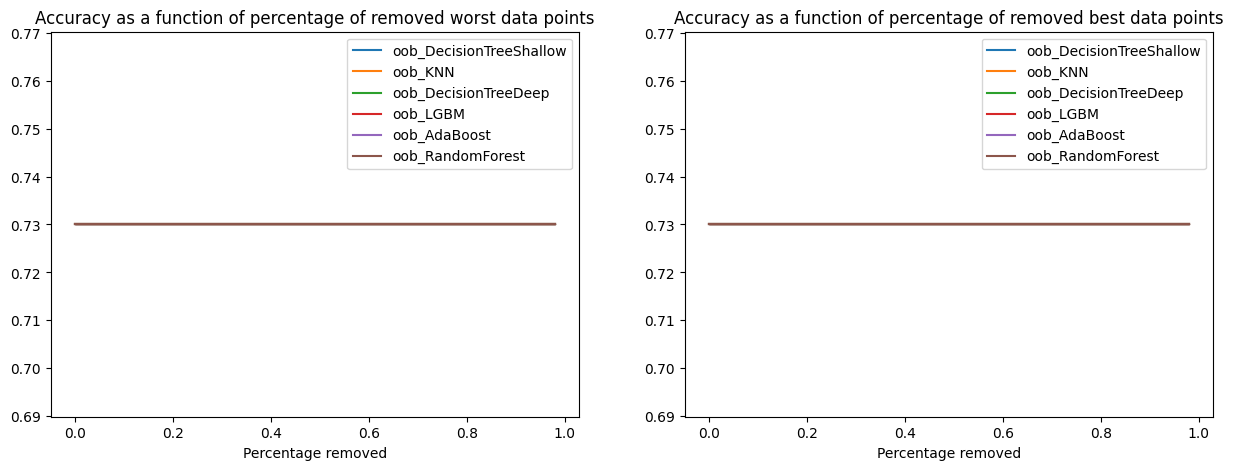

In [25]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="tab10")

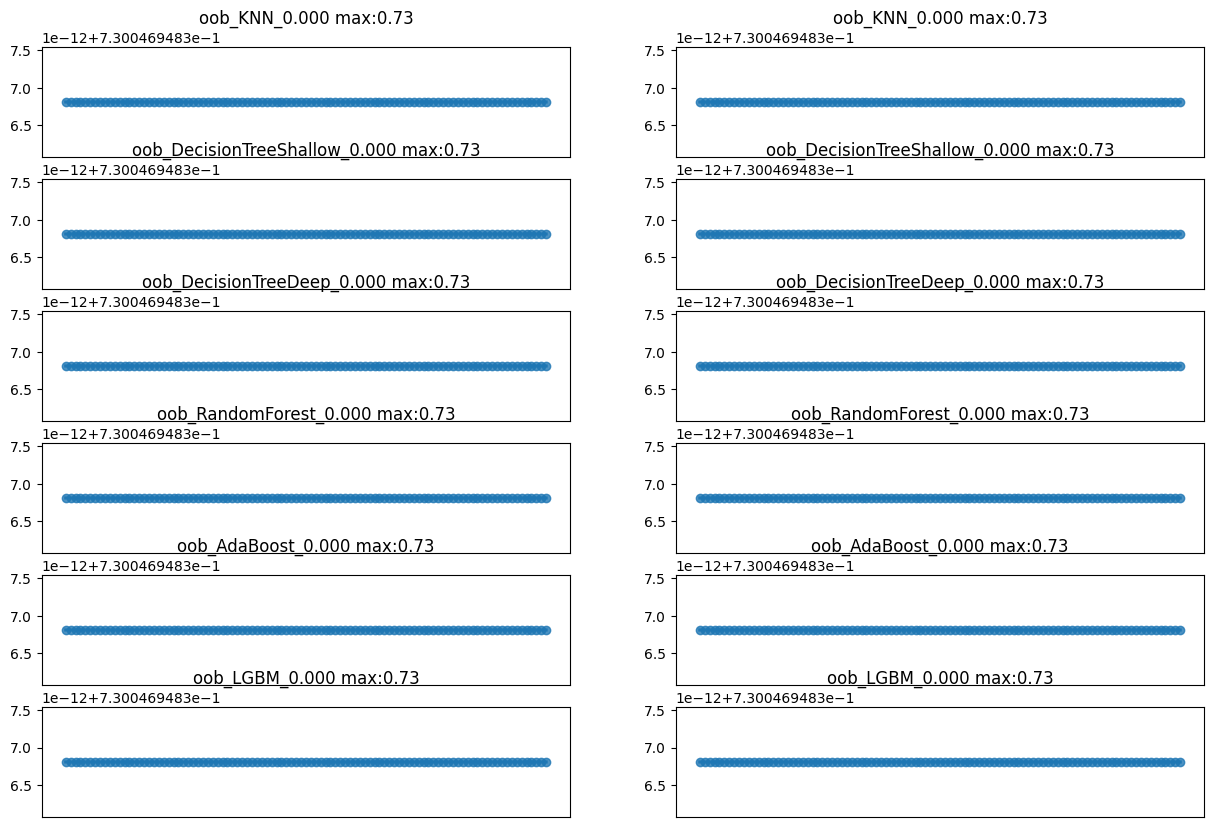

In [26]:
fig, ax = plt.subplots(ncols=2, nrows=best_scores_df.method_name.nunique(), figsize = [15,10])
for i, x in enumerate(best_scores_df.method_name.unique()):
    p=sns.regplot(x=np.arange(len(best_scores_df.groupby("method_name").mean().values[i])), y =best_scores_df.groupby("method_name").mean().loc[x].values, ax=ax[i,1])
    y_data = p.get_lines()[0].get_ydata()
    maxi = best_scores_df.groupby("method_name").mean().loc[x].max()
    ax[i,1].set_title(f"{x}_{y_data[-1]-y_data[0]:.3f} max:{maxi:.2f}")
    ax[i,1].set_xticks([])
    p=sns.regplot(x=np.arange(len(worst_scores_df.groupby("method_name").mean().values[i])), y =worst_scores_df.groupby("method_name").mean().loc[x].values, ax=ax[i,0])
    y_data = p.get_lines()[0].get_ydata()
    maxi = worst_scores_df.groupby("method_name").mean().loc[x].max()
    ax[i,0].set_title(f"{x}_{y_data[-1]-y_data[0]:.3f} max:{maxi:.2f}")
    ax[i,0].set_xticks([])